Workflow followed according to: https://gatk.broadinstitute.org/hc/en-us/articles/360035531192-RNAseq-short-variant-discovery-SNPs-Indels

Github workflow for GATK4 here: https://github.com/gatk-workflows/gatk4-rnaseq-germline-snps-indels/blob/master/gatk4-rna-best-practices.wdl

In [1]:
import os
import pysam
import pandas as pd
from tqdm import tqdm
from varseek.utils import calculate_metrics, draw_confusion_matrix, create_venn_diagram, calculate_sensitivity_specificity, create_stratified_metric_bar_plot, add_vcf_info_to_cosmic_tsv, merge_gatk_and_cosmic, vcf_to_dataframe, safe_literal_eval

In [2]:
import random

def generate_random_fastq(output_path, num_sequences=5000, seq_length=150, quality_score="I"):
    if not os.path.exists(output_path):
        if not os.path.exists(os.path.dirname(output_path)):
            os.makedirs(os.path.dirname(output_path))
        bases = ['A', 'C', 'G', 'T']
        with open(output_path, "w") as fastq_file:
            for i in range(num_sequences):
                # Generate a random sequence of the specified length
                sequence = ''.join(random.choices(bases, k=seq_length))
                
                # Create a quality string of the same length, filled with the specified quality score
                quality = quality_score * seq_length
                
                # Write the FASTQ entry
                fastq_file.write(f"@seq_{i + 1}\n")
                fastq_file.write(f"{sequence}\n")
                fastq_file.write("+\n")
                fastq_file.write(f"{quality}\n")

In [2]:
synthetic_read_fastq = "/home/jrich/data/varseek_data_fresh/manuscript_worthy/vk_sim_2024dec17_complex_testing/synthetic_reads.fq"  #!!! update path
unique_mcrs_df_path = "/home/jrich/data/varseek_data_fresh/manuscript_worthy/vk_sim_2024dec17_complex_testing/unique_mcrs_df.csv"  #!!! update path
gatk_parent = "/home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing"  #!!! update for each run
# generate_random_fastq(synthetic_read_fastq)

threads = 32
read_length = 150
mutation_source = "cdna"  # "cdna", "cds"
mark_duplicates = True
apply_bqsr = True
apply_mutation_filters = False

cosmic_tsv = "/home/jrich/data/varseek_data/reference/cosmic/CancerMutationCensus_AllData_Tsv_v100_GRCh37/CancerMutationCensus_AllData_v100_GRCh37.tsv"
cosmic_cdna_info_csv = "/home/jrich/data/varseek_data/reference/cosmic/CancerMutationCensus_AllData_Tsv_v100_GRCh37/CancerMutationCensus_AllData_v100_GRCh37_mutation_workflow_with_cdna.csv"

# if these paths don't exist then they will be created
reference_genome_fasta = "/home/jrich/data/varseek_data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa"
reference_genome_gtf = "/home/jrich/data/varseek_data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf"
genomes1000_vcf = "/home/jrich/data/varseek_data/reference/ensembl_grch37_release93/1000GENOMES-phase_3.vcf"
ensembl_germline_vcf = "/home/jrich/data/varseek_data/reference/ensembl_grch37_release93/homo_sapiens.vcf"
star_genome_dir = "/home/jrich/data/varseek_data/reference/ensembl_grch37_release93/star_reference"

STAR = "/home/jrich/opt/STAR-2.7.11b/bin/Linux_x86_64/STAR"
java = "/home/jrich/opt/java/jdk-17.0.12+7/bin/java"
picard_jar = "/home/jrich/opt/picard.jar"  # previously in picard/build/libs
gatk = "/home/jrich/opt/gatk-4.6.0.0/gatk"

In [4]:
java_home = os.path.dirname(os.path.dirname(java))

os.environ['JAVA_HOME'] = java_home
os.environ['PATH'] = f"{os.environ['JAVA_HOME']}/bin:" + os.environ['PATH']

os.makedirs(star_genome_dir, exist_ok=True)

alignment_folder = f"{gatk_parent}/alignment"
os.makedirs(alignment_folder, exist_ok=True)

gatk_supporting_files = f"{gatk_parent}/supporting_files"
os.makedirs(gatk_supporting_files, exist_ok=True)

plot_output_folder = f"{gatk_parent}/plots"
os.makedirs(plot_output_folder, exist_ok=True)

ensembl_germline_vcf_filtered = ensembl_germline_vcf.replace(".vcf", "_filtered.vcf")

out_file_name_prefix = f"{alignment_folder}/sample_"

vcf_folder = f"{gatk_parent}/vcfs"
haplotypecaller_folder = f"{vcf_folder}/haplotypecaller"
mutect2_folder = f"{vcf_folder}/mutect2"

os.makedirs(vcf_folder, exist_ok=True)
os.makedirs(haplotypecaller_folder, exist_ok=True)
os.makedirs(mutect2_folder, exist_ok=True)

aligned_and_unmapped_bam = f"{out_file_name_prefix}Aligned.sortedByCoord.out.bam"
aligned_only_bam = f"{alignment_folder}/aligned_only.bam"
unmapped_bam = f"{alignment_folder}/unmapped.bam"
merged_bam = f"{alignment_folder}/merged.bam"

marked_duplicates_bam = f"{alignment_folder}/marked_duplicates.bam" if mark_duplicates else merged_bam
marked_dup_metrics_txt = f"{alignment_folder}/marked_dup_metrics.txt"


split_n_cigar_reads_bam = f"{alignment_folder}/split_n_cigar_reads.bam"
recal_data_table = f"{alignment_folder}/recal_data.table"
recalibrated_bam = f"{alignment_folder}/recalibrated.bam" if apply_bqsr else split_n_cigar_reads_bam
covariates_plot = f"{alignment_folder}/AnalyzeCovariates.pdf"
haplotypecaller_unfiltered_vcf = f"{haplotypecaller_folder}/haplotypecaller_output_unfiltered.g.vcf.gz"

haplotypecaller_filtered_vcf = f"{haplotypecaller_folder}/haplotypecaller_output_filtered.vcf.gz"
haplotypecaller_filtered_applied_vcf = f"{haplotypecaller_folder}/haplotypecaller_output_filtered_applied.vcf.gz"

panel_of_normals_vcf = f"{gatk_supporting_files}/1000g_pon.hg38.vcf.gz"
panel_of_normals_vcf_filtered = f"{gatk_supporting_files}/1000g_pon.hg38_filtered.vcf.gz"
mutect2_unfiltered_vcf = f"{mutect2_folder}/mutect2_output_unfiltered.g.vcf.gz"
mutect2_filtered_vcf = f"{mutect2_folder}/mutect2_output_filtered.vcf.gz"
mutect2_filtered_applied_vcf = f"{mutect2_folder}/mutect2_output_filtered_applied.vcf.gz"

if apply_mutation_filters:
    haplotypecaller_vcf_final = haplotypecaller_filtered_applied_vcf
    mutect2_vcf_final = mutect2_filtered_applied_vcf
else:
    haplotypecaller_vcf_final = haplotypecaller_unfiltered_vcf
    mutect2_vcf_final = mutect2_unfiltered_vcf

In [5]:
if not os.path.exists(reference_genome_fasta):
    !wget -O {reference_genome_fasta}.gz https://ftp.ensembl.org/pub/grch37/release-93/fasta/homo_sapiens/dna/Homo_sapiens.GRCh37.dna.primary_assembly.fa.gz && gunzip {reference_genome_fasta}.gz

if not os.path.exists(reference_genome_gtf):
    !wget -O {reference_genome_gtf}.gz https://ftp.ensembl.org/pub/grch37/release-93/gtf/homo_sapiens/Homo_sapiens.GRCh37.87.gtf.gz && gunzip {reference_genome_gtf}.gz

if not os.path.exists(genomes1000_vcf):
    !wget -O {genomes1000_vcf}.gz https://ftp.ensembl.org/pub/grch37/release-93/variation/vcf/homo_sapiens/1000GENOMES-phase_3.vcf.gz && gunzip {genomes1000_vcf}.gz
    
if not os.path.exists(ensembl_germline_vcf):
    !wget -O {ensembl_germline_vcf}.gz https://ftp.ensembl.org/pub/grch37/release-93/variation/vcf/homo_sapiens/homo_sapiens.vcf.gz && gunzip {ensembl_germline_vcf}.gz

if not os.path.exists(ensembl_germline_vcf_filtered):
    ensembl_germline_vcf_temp1 = ensembl_germline_vcf.replace(".vcf", "_temp1.vcf")
    # ensembl_germline_vcf_temp2 = ensembl_germline_vcf.replace(".vcf", "_temp2.vcf")
    !grep -vP '^[^\t]*\t[^\t]*\t[^\t]*\t[^\t]*[WH]|^[^\t]*\t[^\t]*\t[^\t]*\t[^\t]*\t[^\t]*[WH]' $ensembl_germline_vcf > $ensembl_germline_vcf_temp1
    !grep -vP '^[^\t]*\t[^\t]*\t[^\t]*\t\t|^[^\t]*\t[^\t]*\t[^\t]*\t[^\t]*\t\t' $ensembl_germline_vcf_temp1 > $ensembl_germline_vcf_filtered
    !rm $ensembl_germline_vcf_temp1

# if not os.path.exists(panel_of_normals_vcf):
#     !wget -P {gatk_supporting_files} https://storage.googleapis.com/gatk-best-practices/somatic-hg38/1000g_pon.hg38.vcf.gz
#     !wget -P {gatk_supporting_files} https://storage.googleapis.com/gatk-best-practices/somatic-hg38/1000g_pon.hg38.vcf.gz.tbi

# if not os.path.exists(panel_of_normals_vcf_filtered):
#     decompressed_pon_vcf = panel_of_normals_vcf.replace(".vcf.gz", ".vcf")
#     !gunzip -c $panel_of_normals_vcf > $decompressed_pon_vcf
    
#     # Remove 'chr' prefix from data lines
#     !sed -i 's/^chr//' $decompressed_pon_vcf

#     # Remove 'chr' prefix from contig headers in the VCF
#     !sed -i '/^##contig/s/ID=chr/ID=/' $decompressed_pon_vcf

#     # gunzip again
#     !bgzip -c $decompressed_pon_vcf > $panel_of_normals_vcf_filtered  # TODO: get bgzip installed

1. Mapping to the Reference with STAR

In [6]:
read_length_minus_one = read_length - 1

if not os.listdir(star_genome_dir):
    !$STAR \
        --runThreadN $threads \
        --runMode genomeGenerate \
        --genomeDir $star_genome_dir \
        --genomeFastaFiles $reference_genome_fasta \
        --sjdbGTFfile $reference_genome_gtf \
        --sjdbOverhang $read_length_minus_one

In [7]:
#* --outSAMmapqUnique 60 - changed from default of 255 to avoid colliding with some aligners' use of 255 as a special value

!$STAR \
    --runThreadN $threads \
    --genomeDir $star_genome_dir \
    --readFilesIn $synthetic_read_fastq \
    --sjdbOverhang $read_length_minus_one \
    --outFileNamePrefix $out_file_name_prefix \
    --outSAMtype BAM SortedByCoordinate \
    --outSAMunmapped Within \
    --outSAMmapqUnique 60 \
    --twopassMode Basic



	/home/jrich/opt/STAR-2.7.11b/source/STAR --runThreadN 32 --genomeDir /home/jrich/data/varseek_data/reference/ensembl_grch37_release93/star_reference --readFilesIn /home/jrich/data/varseek_data_fresh/manuscript_worthy/vk_sim_2024dec17_complex_testing/synthetic_reads.fq --sjdbOverhang 149 --outFileNamePrefix /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/sample_ --outSAMtype BAM SortedByCoordinate --outSAMunmapped Within --outSAMmapqUnique 60 --twopassMode Basic
	STAR version: 2.7.11b   compiled: 2024-07-22T09:22:47-0700 dator:/home/jrich/opt/STAR-2.7.11b/source
Jan 06 11:34:56 ..... started STAR run
Jan 06 11:34:56 ..... loading genome
Jan 06 11:35:35 ..... started 1st pass mapping
Jan 06 11:36:55 ..... finished 1st pass mapping
Jan 06 11:36:56 ..... inserting junctions into the genome indices
Jan 06 11:38:36 ..... started mapping
Jan 06 11:39:54 ..... finished mapping
Jan 06 11:39:59 ..... started sorting BAM
Jan 06 11:40:24 ..... finish

Separate unmapped reads into its own BAM file

In [8]:
# with pysam.AlignmentFile(aligned_and_unmapped_bam, "rb") as bam_in: 
#     # unmapped_header = bam_in.header.to_dict()
#     # if 'PG' in unmapped_header:
#     #     del unmapped_header['PG']
           
#     with pysam.AlignmentFile(aligned_only_bam, "wb", template=bam_in) as bam_aligned_out, pysam.AlignmentFile(unmapped_bam, "wb", template=bam_in) as bam_unmapped_out:
#         for read in bam_in:
#             if read.is_unmapped:
#                 bam_unmapped_out.write(read)  # Write unmapped read to the unmapped BAM file
#             else:
#                 bam_aligned_out.write(read)  # Write aligned read to the aligned BAM file

# print(f"Unmapped reads written to {unmapped_bam}")

#

In [9]:
!$java -jar $picard_jar FastqToSam \
    -FASTQ $synthetic_read_fastq \
    -OUTPUT $unmapped_bam \
    -READ_GROUP_NAME rg1 \
    -SAMPLE_NAME sample1 \
    -LIBRARY_NAME lib1 \
    -PLATFORM_UNIT unit1 \
    -PLATFORM ILLUMINA \
    -SEQUENCING_CENTER center1

11:40:30.704 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jrich/opt/picard/build/libs/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Mon Jan 06 11:40:30 PST 2025] FastqToSam --FASTQ /home/jrich/data/varseek_data_fresh/manuscript_worthy/vk_sim_2024dec17_complex_testing/synthetic_reads.fq --OUTPUT /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/unmapped.bam --READ_GROUP_NAME rg1 --SAMPLE_NAME sample1 --LIBRARY_NAME lib1 --PLATFORM_UNIT unit1 --PLATFORM ILLUMINA --SEQUENCING_CENTER center1 --USE_SEQUENTIAL_FASTQS false --SORT_ORDER queryname --MIN_Q 0 --MAX_Q 93 --STRIP_UNPAIRED_MATE_NUMBER false --ALLOW_AND_IGNORE_EMPTY_LINES false --ALLOW_EMPTY_FASTQ false --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 5 --MAX_RECORDS_IN_RAM 500000 --CREATE_INDEX false --CREATE_MD5_FILE false --help false --version false --showHidden false --USE_JDK_DEFLATER false --USE_JDK_INFLATE

INFO	2025-01-06 11:41:08	FastqToSam	Processed    14,000,000 records.  Elapsed time: 00:00:37s.  Time for last 1,000,000:    2s.  Last read position: */*
INFO	2025-01-06 11:41:10	FastqToSam	Processed    15,000,000 records.  Elapsed time: 00:00:39s.  Time for last 1,000,000:    2s.  Last read position: */*
INFO	2025-01-06 11:41:14	FastqToSam	Processed    16,000,000 records.  Elapsed time: 00:00:43s.  Time for last 1,000,000:    3s.  Last read position: */*
INFO	2025-01-06 11:41:17	FastqToSam	Processed    17,000,000 records.  Elapsed time: 00:00:46s.  Time for last 1,000,000:    2s.  Last read position: */*
INFO	2025-01-06 11:41:19	FastqToSam	Processed    18,000,000 records.  Elapsed time: 00:00:48s.  Time for last 1,000,000:    2s.  Last read position: */*
INFO	2025-01-06 11:41:21	FastqToSam	Processed    19,000,000 records.  Elapsed time: 00:00:50s.  Time for last 1,000,000:    2s.  Last read position: */*
INFO	2025-01-06 11:41:25	FastqToSam	Processed    20,000,000 records.  Elapsed time

2. MergeBamAlignment

In [10]:
reference_genome_dict = reference_genome_fasta.replace(".fa", ".dict")

!$java -jar $picard_jar CreateSequenceDictionary \
    -R $reference_genome_fasta \
    -O $reference_genome_dict

11:43:11.445 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jrich/opt/picard/build/libs/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Mon Jan 06 11:43:11 PST 2025] CreateSequenceDictionary --OUTPUT /home/jrich/data/varseek_data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.dict --REFERENCE /home/jrich/data/varseek_data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa --TRUNCATE_NAMES_AT_WHITESPACE true --NUM_SEQUENCES 2147483647 --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 5 --MAX_RECORDS_IN_RAM 500000 --CREATE_INDEX false --CREATE_MD5_FILE false --help false --version false --showHidden false --USE_JDK_DEFLATER false --USE_JDK_INFLATER false
[Mon Jan 06 11:43:11 PST 2025] Executing as jrich@dator on Linux 3.10.0-1127.13.1.el7.x86_64 amd64; OpenJDK 64-Bit Server VM 17.0.12+7; Deflater: Intel; Inflater: Intel; Provider GCS is available; Picard version

In [11]:
!$java -jar $picard_jar MergeBamAlignment \
    --ALIGNED_BAM $aligned_and_unmapped_bam \
    --UNMAPPED_BAM $unmapped_bam \
    --OUTPUT $merged_bam \
    --REFERENCE_SEQUENCE $reference_genome_fasta \
    --SORT_ORDER coordinate \
    --INCLUDE_SECONDARY_ALIGNMENTS false \
    --VALIDATION_STRINGENCY SILENT



11:43:12.812 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jrich/opt/picard/build/libs/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Mon Jan 06 11:43:12 PST 2025] MergeBamAlignment --UNMAPPED_BAM /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/unmapped.bam --ALIGNED_BAM /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/sample_Aligned.sortedByCoord.out.bam --OUTPUT /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/merged.bam --SORT_ORDER coordinate --INCLUDE_SECONDARY_ALIGNMENTS false --VALIDATION_STRINGENCY SILENT --REFERENCE_SEQUENCE /home/jrich/data/varseek_data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa --ADD_PG_TAG_TO_READS true --PAIRED_RUN true --CLIP_ADAPTERS true --IS_BISULFITE_SEQUENCE false --ALIGNED_READS_ONLY false --MAX_INSERTIONS_OR_DELETIONS 1 --ATTRIBUTES_TO_

INFO	2025-01-06 11:44:11	AbstractAlignmentMerger	Merged     1,000,000 records.  Elapsed time: 00:00:58s.  Time for last 1,000,000:    7s.  Last read position: 6:155,153,078.  Last read name: vcrs_0201910_123rW_row3883
INFO	2025-01-06 11:44:17	AbstractAlignmentMerger	Merged     2,000,000 records.  Elapsed time: 00:01:04s.  Time for last 1,000,000:    6s.  Last read position: 17:36,483,810.  Last read name: vcrs_0410165_75fW_row86263
INFO	2025-01-06 11:44:23	AbstractAlignmentMerger	Merged     3,000,000 records.  Elapsed time: 00:01:10s.  Time for last 1,000,000:    6s.  Last read position: 6:25,727,268.  Last read name: vcrs_0616360_139rW_row45499
INFO	2025-01-06 11:44:28	AbstractAlignmentMerger	Merged     4,000,000 records.  Elapsed time: 00:01:15s.  Time for last 1,000,000:    5s.  Last read position: 5:192,527.  Last read name: vcrs_0817410_88fM_row43819
INFO	2025-01-06 11:44:35	AbstractAlignmentMerger	Merged     5,000,000 records.  Elapsed time: 00:01:22s.  Time for last 1,000,000:  

3. MarkDuplicates

In [12]:
if mark_duplicates:
      !$java -jar $picard_jar MarkDuplicates \
            --INPUT $merged_bam \
            --OUTPUT $marked_duplicates_bam \
            --METRICS_FILE $marked_dup_metrics_txt \
            --CREATE_INDEX true \
            --VALIDATION_STRINGENCY SILENT

11:50:02.492 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jrich/opt/picard/build/libs/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Mon Jan 06 11:50:02 PST 2025] MarkDuplicates --INPUT /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/merged.bam --OUTPUT /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/marked_duplicates.bam --METRICS_FILE /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/marked_dup_metrics.txt --VALIDATION_STRINGENCY SILENT --CREATE_INDEX true --MAX_SEQUENCES_FOR_DISK_READ_ENDS_MAP 50000 --MAX_FILE_HANDLES_FOR_READ_ENDS_MAP 8000 --SORTING_COLLECTION_SIZE_RATIO 0.25 --TAG_DUPLICATE_SET_MEMBERS false --REMOVE_SEQUENCING_DUPLICATES false --TAGGING_POLICY DontTag --CLEAR_DT true --DUPLEX_UMI false --FLOW_MODE false --FLOW_DUP_STRATEGY FLOW_QUALITY_SUM_STRATEGY --USE_END_IN_UNPAIRED_READS false --U

4. SplitNCigarReads

In [13]:
_ = pysam.faidx(reference_genome_fasta)

!$gatk SplitNCigarReads \
    -R $reference_genome_fasta \
    -I $marked_duplicates_bam \
    -O $split_n_cigar_reads_bam

Using GATK jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar SplitNCigarReads -R /home/jrich/data/varseek_data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa -I /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/marked_duplicates.bam -O /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/split_n_cigar_reads.bam
11:54:50.835 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
11:54:51.018 INFO  SplitNCigarReads - ------------------------------------------------------------
11:54:51.023 INFO  SplitNCig

11:55:11.264 INFO  ProgressMeter -           1:40733501              0.3                750000        2249100.4
11:55:21.284 INFO  ProgressMeter -           1:77093220              0.5               1086000        2169974.7
11:55:31.318 INFO  ProgressMeter -          1:119619035              0.7               1431000        2143178.1
11:55:41.319 INFO  ProgressMeter -          1:156498720              0.8               1832000        2195677.4
11:55:51.332 INFO  ProgressMeter -          1:179530426              1.0               2213000        2210200.4
11:56:01.345 INFO  ProgressMeter -          1:213341201              1.2               2580000        2208652.0
11:56:11.346 INFO  ProgressMeter -          1:247063720              1.3               2915000        2183847.8
11:56:21.356 INFO  ProgressMeter -          10:46999490              1.5               3326000        2214872.4
11:56:31.358 INFO  ProgressMeter -          10:92508784              1.7               3691000        22

5. BaseRecalibrator

In [14]:
##  -I in old version, -F in new version
# if not os.path.exists(f"{ensembl_germline_vcf_filtered}.idx"):
#     !$gatk IndexFeatureFile -I $ensembl_germline_vcf_filtered  # TODO: ~81092000/324780532 processed before error - current error being a duplicate G in REF/ALT column

if not os.path.exists(f"{genomes1000_vcf}.idx"):
    !$gatk IndexFeatureFile -I $genomes1000_vcf

# TODO: uncomment once I install bgzip
# if not os.path.exists(f"{panel_of_normals_vcf_filtered}.idx"):
#     !gatk IndexFeatureFile -I $panel_of_normals_vcf_filtered

In [15]:
# TODO: when I fix !$gatk IndexFeatureFile -I $ensembl_germline_vcf_filtered, add back --known-sites $ensembl_germline_vcf_filtered
!$gatk BaseRecalibrator \
    -I $split_n_cigar_reads_bam \
    -R $reference_genome_fasta \
    --use-original-qualities \
    --known-sites $genomes1000_vcf \
    -O $recal_data_table

# -known-sites ${dbSNP_vcf} \
# -known-sites ${sep=" --known-sites " known_indels_sites_VCFs}

Using GATK jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar BaseRecalibrator -I /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/split_n_cigar_reads.bam -R /home/jrich/data/varseek_data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa --use-original-qualities --known-sites /home/jrich/data/varseek_data/reference/ensembl_grch37_release93/1000GENOMES-phase_3.vcf -O /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/recal_data.table
12:33:12.117 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
12:3

12:34:13.007 INFO  ProgressMeter -          10:98988904              1.0               3730000        3726335.8
12:34:23.016 INFO  ProgressMeter -          11:14990420              1.2               4432000        3795116.2
12:34:33.023 INFO  ProgressMeter -          11:67838276              1.3               5150000        3858834.1
12:34:43.024 INFO  ProgressMeter -         11:132081916              1.5               5791000        3857409.3
12:34:53.026 INFO  ProgressMeter -          12:52966237              1.7               6506000        3900518.6
12:35:03.026 INFO  ProgressMeter -         12:116445351              1.8               7230000        3940806.1
12:35:13.037 INFO  ProgressMeter -         13:100192968              2.0               7913000        3953534.8
12:35:23.042 INFO  ProgressMeter -          14:78146223              2.2               8629000        3979707.1
12:35:33.081 INFO  ProgressMeter -          15:55652662              2.3               9337000        39

6. Apply Recalibration

In [16]:
if apply_bqsr:
    !$gatk ApplyBQSR \
        --add-output-sam-program-record \
        -R $reference_genome_fasta \
        -I $split_n_cigar_reads_bam \
        --use-original-qualities \
        --bqsr-recal-file $recal_data_table \
        -O $recalibrated_bam



Using GATK jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar ApplyBQSR --add-output-sam-program-record -R /home/jrich/data/varseek_data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa -I /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/split_n_cigar_reads.bam --use-original-qualities --bqsr-recal-file /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/recal_data.table -O /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/recalibrated.bam
12:40:32.782 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.

7. AnalyzeCovariates

In [17]:
!$gatk AnalyzeCovariates \
    -bqsr $recal_data_table \
    -plots $covariates_plot



Using GATK jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar AnalyzeCovariates -bqsr /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/recal_data.table -plots /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/AnalyzeCovariates.pdf
12:52:46.388 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
12:52:46.537 INFO  AnalyzeCovariates - ------------------------------------------------------------
12:52:46.542 INFO  AnalyzeCovariates - The Genome Analysis Toolkit (GATK) v4.6.0.0
12:52:46.542 INFO  AnalyzeCovariates - For support and 

8a. HaplotypeCaller

In [18]:

!$gatk --java-options "-Xmx4g" HaplotypeCaller  \
    -R $reference_genome_fasta \
    -I $recalibrated_bam \
    -O $haplotypecaller_unfiltered_vcf \
    --dont-use-soft-clipped-bases \
    --disable-tool-default-read-filters \
    --standard-min-confidence-threshold-for-calling 10



Using GATK jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -Xmx4g -jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar HaplotypeCaller -R /home/jrich/data/varseek_data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa -I /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/recalibrated.bam -O /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/vcfs/haplotypecaller/haplotypecaller_output_unfiltered.g.vcf.gz --dont-use-soft-clipped-bases --disable-tool-default-read-filters --standard-min-confidence-threshold-for-calling 10
12:52:49.302 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar!/com/intel/gkl/native/l

12:53:09.985 INFO  ProgressMeter -            1:6314157              0.3                 22560          67263.0
12:53:19.986 INFO  ProgressMeter -           1:11266311              0.5                 40110          79887.1
12:53:30.032 INFO  ProgressMeter -           1:14109977              0.7                 50430          75323.0
12:53:40.097 INFO  ProgressMeter -           1:18808613              0.8                 67030          80058.1
12:53:50.099 INFO  ProgressMeter -           1:23418694              1.0                 83690          83359.3
12:54:04.970 INFO  ProgressMeter -           1:27023496              1.3                 96610          77176.9
12:54:15.483 INFO  ProgressMeter -           1:27098168              1.4                 96880          67889.1
12:54:26.904 INFO  ProgressMeter -           1:27103749              1.6                 96920          59924.0
12:54:37.585 INFO  ProgressMeter -           1:27106807              1.8                 96940          

8.5a. MergeVcfs

In [19]:
# merged_vcf = haplotypecaller_merged.vcf
# 
# !$java -jar $picard_jar MergeVcfs \
#     --INPUT $vcf1 \
#     --INPUT $vcf2 \
#     --OUTPUT $merged_vcf

9a. VariantFiltration

In [20]:
# cosmic_vcf = ""

!$gatk VariantFiltration \
    -R $reference_genome_fasta \
    -V $haplotypecaller_unfiltered_vcf \
    -O $haplotypecaller_filtered_vcf \
    --window 35 \
    --cluster 3 \
    --filter-name "FS" \
    --filter "FS > 30.0" \
    --filter-name "QD" \
    --filter "QD < 2.0"

    # --mask $cosmic_vcf \
    # --mask-name "COSMIC" \
    # --filter-not-in-mask \



Using GATK jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar VariantFiltration -R /home/jrich/data/varseek_data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa -V /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/vcfs/haplotypecaller/haplotypecaller_output_unfiltered.g.vcf.gz -O /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/vcfs/haplotypecaller/haplotypecaller_output_filtered.vcf.gz --window 35 --cluster 3 --filter-name FS --filter FS > 30.0 --filter-name QD --filter QD < 2.0
14:11:30.186 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar!/com/intel/gkl/na

10a. Do the filtering

In [21]:
!$gatk SelectVariants \
     -V $haplotypecaller_filtered_vcf \
     --exclude-filtered true \
     -O $haplotypecaller_filtered_applied_vcf

Using GATK jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar SelectVariants -V /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/vcfs/haplotypecaller/haplotypecaller_output_filtered.vcf.gz --exclude-filtered true -O /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/vcfs/haplotypecaller/haplotypecaller_output_filtered_applied.vcf.gz
14:11:42.673 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
14:11:42.812 INFO  SelectVariants - ------------------------------------------------------------
14:11:42.817 INFO  SelectVariants - The Genome Analysis To

8b. Mutect2

In [22]:
# consider adding --disable-read-filter
# TODO: add --panel-of-normals $panel_of_normals_vcf_filtered once I install bgzip
!$gatk Mutect2 \
    -R $reference_genome_fasta \
    -I $recalibrated_bam \
    -O $mutect2_unfiltered_vcf \
    --disable-tool-default-read-filters \
    --min-base-quality-score 10



Using GATK jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar Mutect2 -R /home/jrich/data/varseek_data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa -I /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/alignment/recalibrated.bam -O /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/vcfs/mutect2/mutect2_output_unfiltered.g.vcf.gz --disable-tool-default-read-filters --min-base-quality-score 10
14:11:47.026 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
14:11:47.172 INFO  Mutect2 - ----------------------------------

14:12:07.577 INFO  ProgressMeter -            1:6029365              0.3                 21650          64930.5
14:12:17.588 INFO  ProgressMeter -            1:9064515              0.5                 32430          64823.3
14:12:27.593 INFO  ProgressMeter -           1:12248816              0.7                 44120          66145.3
14:12:37.989 INFO  ProgressMeter -           1:13146618              0.8                 47440          56456.0
14:12:48.280 INFO  ProgressMeter -           1:16260182              1.0                 58280          57599.4
14:12:58.471 INFO  ProgressMeter -           1:18810627              1.2                 67530          57148.1
14:13:08.471 INFO  ProgressMeter -           1:22903164              1.3                 82450          61149.6
14:13:18.473 INFO  ProgressMeter -           1:26360685              1.5                 94840          62599.3
14:13:33.382 INFO  ProgressMeter -           1:27024969              1.8                 97330          

9b. FilterMutectCalls

In [23]:
# # if multiple stats files:
# !$gatk MergeMutectStats -stats unfiltered1.vcf.stats -stats unfiltered2.vcf.stats -O unfiltered.vcf.stats

# stats_file = f"{mutect2_unfiltered_vcf}.stats"
# --stats $stats_file
!$gatk FilterMutectCalls \
    -R $reference_genome_fasta \
    -V $mutect2_unfiltered_vcf \
    -O $mutect2_filtered_vcf



Using GATK jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar FilterMutectCalls -R /home/jrich/data/varseek_data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa -V /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/vcfs/mutect2/mutect2_output_unfiltered.g.vcf.gz -O /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/vcfs/mutect2/mutect2_output_filtered.vcf.gz
15:55:55.954 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
15:55:56.095 INFO  FilterMutectCalls - ------------------------------------------------------------


15:56:12.395 INFO  FilterMutectCalls - Finished pass 0 through the variants
15:57:16.447 INFO  FilterMutectCalls - Starting pass 1 through the variants
15:57:16.526 INFO  ProgressMeter -            1:6525246              1.3                224000         168271.3
15:57:26.585 INFO  ProgressMeter -          20:61525370              1.5                359000         239519.6
15:57:32.848 INFO  FilterMutectCalls - Finished pass 1 through the variants
15:57:42.820 INFO  FilterMutectCalls - Starting pass 2 through the variants
15:57:42.880 INFO  ProgressMeter -            1:3684000              1.8                447000         252485.3
15:57:52.899 INFO  ProgressMeter -           3:44492922              1.9                592000         305566.8
15:57:58.134 INFO  FilterMutectCalls - Finished pass 2 through the variants
15:57:58.189 INFO  FilterMutectCalls - Starting pass 3 through the variants
15:58:02.925 INFO  ProgressMeter -          12:65462656              2.1                721000  

In [24]:
!$gatk SelectVariants \
     -V $mutect2_filtered_vcf \
     --exclude-filtered true \
     -O $mutect2_filtered_applied_vcf

Using GATK jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar SelectVariants -V /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/vcfs/mutect2/mutect2_output_filtered.vcf.gz --exclude-filtered true -O /home/jrich/data/varseek_data_fresh/manuscript_worthy/gatk_2024dec17_complex_testing/vcfs/mutect2/mutect2_output_filtered_applied.vcf.gz
15:58:20.058 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jrich/opt/gatk-4.6.0.0/gatk-package-4.6.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
15:58:20.205 INFO  SelectVariants - ------------------------------------------------------------
15:58:20.210 INFO  SelectVariants - The Genome Analysis Toolkit (GATK) v4.6.0.0
15:58:20.2

In [25]:
# def create_sample_vcf(output_path):
#     with open(output_path, "w") as vcf_file:
#         # Write VCF headers
#         vcf_file.write("##fileformat=VCFv4.2\n")
#         vcf_file.write("##source=SampleVCFGenerator\n")
#         vcf_file.write("##reference=GRCh37\n")
#         vcf_file.write("##INFO=<ID=DP,Number=1,Type=Integer,Description=\"Total Depth\">\n")
#         vcf_file.write("##INFO=<ID=AF,Number=A,Type=Float,Description=\"Allele Frequency\">\n")
#         vcf_file.write("##FILTER=<ID=PASS,Description=\"All filters passed\">\n")
#         vcf_file.write("##FORMAT=<ID=GT,Number=1,Type=String,Description=\"Genotype\">\n")
#         vcf_file.write("#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\tsample1\n")
        
#         # Write sample variant entries
#         variants = [
#             ("1", 123456, ".", "G", "A", 50, "PASS", "DP=100;AF=0.5", "GT", "0/1"),
#             ("1", 234567, ".", "C", "T", 60, "PASS", "DP=200;AF=0.3", "GT", "1/1"),
#             ("2", 345678, ".", "T", "G", 70, "PASS", "DP=150;AF=0.1", "GT", "0/1"),
#             ("X", 456789, ".", "A", "C", 80, "PASS", "DP=120;AF=0.05", "GT", "0/0")
#         ]
        
#         for chrom, pos, var_id, ref, alt, qual, fltr, info, fmt, sample in variants:
#             vcf_file.write(f"{chrom}\t{pos}\t{var_id}\t{ref}\t{alt}\t{qual}\t{fltr}\t{info}\t{fmt}\t{sample}\n")

# # Usage
# create_sample_vcf("/home/jrich/data/varseek_data/gatk/sample.vcf")

# df_sample = vcf_to_dataframe("/home/jrich/data/varseek_data/gatk/sample.vcf")

# JUMP TO HERE

In [5]:
# Convert VCF to DataFrame
df_hap = vcf_to_dataframe(haplotypecaller_vcf_final, additional_columns = True)
df_mut = vcf_to_dataframe(mutect2_vcf_final, additional_columns = True)

df_hap = df_hap[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'INFO_DP']].rename(columns={'INFO_DP': 'DP_gatk_haplotypecaller'})
df_mut = df_mut[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'INFO_DP']].rename(columns={'INFO_DP': 'DP_gatk_mutect2'})

In [6]:
cosmic_df = add_vcf_info_to_cosmic_tsv(cosmic_tsv=cosmic_tsv, reference_genome_fasta=reference_genome_fasta, cosmic_df_out = None, cosmic_cdna_info_csv = cosmic_cdna_info_csv, mutation_source = "cdna")

100%|██████████| 120017/120017 [00:01<00:00, 85017.53it/s]
1it [00:00, 542.46it/s]
1it [00:00, 3148.88it/s]
100%|██████████| 120017/120017 [00:00<00:00, 894873.43it/s] 


In [36]:
# load in unique_mcrs_df
unique_mcrs_df = pd.read_csv(unique_mcrs_df_path)
unique_mcrs_df.rename(columns={'received_an_aligned_read': 'mutation_detected_varseek', 'number_of_reads_aligned_to_this_item': 'DP_varseek', 'mutation_expression_prediction_error': 'mutation_expression_prediction_error_varseek', 'TP_crude': 'TP_varseek', 'FP_crude': 'FP_varseek', 'TN_crude': 'TN_varseek', 'FN_crude': 'FN_varseek', 'TP': 'TP_varseek_read_specific', 'FP': 'FP_varseek_read_specific', 'TN': 'TN_varseek_read_specific', 'FN': 'FN_varseek_read_specific'}, inplace=True)
unique_mcrs_df["header_list"] = unique_mcrs_df["header_list"].apply(safe_literal_eval)

/tmp/ipykernel_52084/3565577588.py:2: DtypeWarning: Columns (36,38) have mixed types. Specify dtype option on import or set low_memory=False.
  unique_mcrs_df = pd.read_csv(unique_mcrs_df_path)


In [8]:
mut_cosmic_merged_df = merge_gatk_and_cosmic(df_mut, cosmic_df, exact_position=False)  # change exact_position to True to merge based on exact position as before
id_set_mut = set(mut_cosmic_merged_df['ID'])

hap_cosmic_merged_df = merge_gatk_and_cosmic(df_hap, cosmic_df, exact_position=False)
id_set_hap = set(hap_cosmic_merged_df['ID'])

In [37]:
# Merge DP values into unique_mcrs_df
# Step 1: Remove rows with NaN values in 'ID' column
mutect2_cosmic_merged_df_for_merging = mut_cosmic_merged_df[['ID', 'DP_gatk_mutect2']].dropna(subset=['ID']).rename(columns={'ID': 'mcrs_header'})

# Step 2: Drop duplicates from 'ID' column
mutect2_cosmic_merged_df_for_merging = mutect2_cosmic_merged_df_for_merging.drop_duplicates(subset=['mcrs_header'])

# Step 3: Left merge with unique_mcrs_df
unique_mcrs_df = pd.merge(
    unique_mcrs_df,               # Left DataFrame
    mutect2_cosmic_merged_df_for_merging,         # Right DataFrame
    on='mcrs_header',
    how='left'
)


# Repeat for haplotypecaller
# Step 1: Remove rows with NaN values in 'ID' column
haplotypecaller_cosmic_merged_df_for_merging = hap_cosmic_merged_df[['ID', 'DP_gatk_haplotypecaller']].dropna(subset=['ID']).rename(columns={'ID': 'mcrs_header'})

# Step 2: Drop duplicates from 'ID' column
haplotypecaller_cosmic_merged_df_for_merging = haplotypecaller_cosmic_merged_df_for_merging.drop_duplicates(subset=['mcrs_header'])

# Step 3: Left merge with unique_mcrs_df
unique_mcrs_df = pd.merge(
    unique_mcrs_df,               # Left DataFrame
    haplotypecaller_cosmic_merged_df_for_merging,         # Right DataFrame
    on='mcrs_header',
    how='left'
)

In [38]:
number_of_mutations_mutect = len(df_mut.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT']))
number_of_cosmic_mutations_mutect = len(mut_cosmic_merged_df.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT']))
number_of_mutations_haplotypecaller = len(df_hap.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT']))
number_of_cosmic_mutations_haplotypecaller = len(hap_cosmic_merged_df.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT']))

TP: 205184, FP: 1545, FN: 175980, TN: 4868833
Accuracy: 0.9661956431082528, Sensitivity: 0.5383089693675164, Specificity: 0.999682776162343
Mean Expression Error: 146.9964134556575, Median Expression Error: 63.0, Mean Magnitude Expression Error: 160.27714740061163, Median Magnitude Expression Error: 72.0


                      Confusion Matrix                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Positive ┃ Predicted Negative ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Actual Positive │       205184       │       175980       │
│ Actual Negative │        1545        │      4868833       │
└─────────────────┴────────────────────┴────────────────────┘

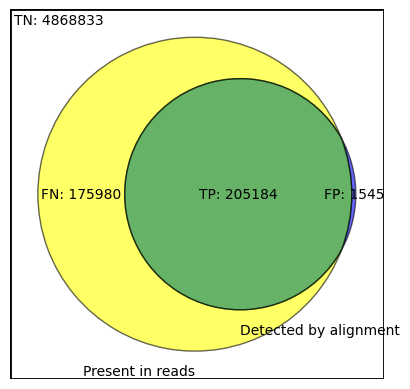

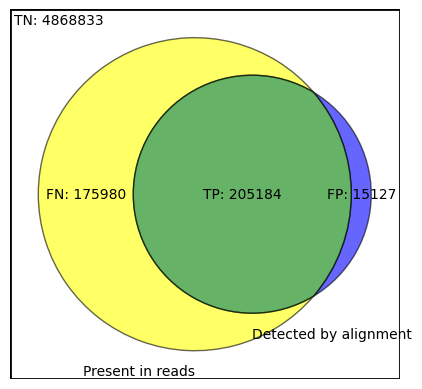

In [53]:
# unique_mcrs_df['header_list'] each contains a list of strings. I would like to make a new column unique_mcrs_df['mutation_detected_gatk_mutect2'] where each row is True if any value from the list unique_mcrs_df['mcrs_header'] is in the set id_set_mut  # keep in mind that my IDs are the mutation headers (ENST...), NOT mcrs headers or mcrs ids
unique_mcrs_df['mutation_detected_gatk_mutect2'] = unique_mcrs_df['header_list'].apply(
    lambda header_list: any(header in id_set_mut for header in header_list)
)

# calculate expression error
unique_mcrs_df['mutation_expression_prediction_error'] = unique_mcrs_df['DP_gatk_mutect2'] - unique_mcrs_df['number_of_reads_mutant']  # positive means overpredicted, negative means underpredicted

unique_mcrs_df['TP'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['mutation_detected_gatk_mutect2'])
unique_mcrs_df['FP'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['mutation_detected_gatk_mutect2'])
unique_mcrs_df['FN'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['mutation_detected_gatk_mutect2'])
unique_mcrs_df['TN'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['mutation_detected_gatk_mutect2'])

mutect_stat_path = f"{gatk_parent}/reference_metrics_mutect2.txt"
metric_dictionary_reference = calculate_metrics(unique_mcrs_df, header_name = "mcrs_header", check_assertions = False, out = mutect_stat_path)
draw_confusion_matrix(metric_dictionary_reference)

true_set = set(unique_mcrs_df.loc[unique_mcrs_df['included_in_synthetic_reads_mutant'], 'mcrs_header'])
positive_set = set(unique_mcrs_df.loc[unique_mcrs_df['mutation_detected_gatk_mutect2'], 'mcrs_header'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reference['TN'], out_path = f"{gatk_parent}/venn_diagram_reference_cosmic_only_mutect2.png")

noncosmic_mutation_id_set = {f'mutect_fp_{i}' for i in range(1, number_of_mutations_mutect - number_of_cosmic_mutations_mutect + 1)}

positive_set_including_noncosmic_mutations = positive_set.union(noncosmic_mutation_id_set)
false_positive_set = set(unique_mcrs_df.loc[unique_mcrs_df['FP'], 'mcrs_header'])
false_positive_set_including_noncosmic_mutations = false_positive_set.union(noncosmic_mutation_id_set)

FP_including_noncosmic = len(false_positive_set_including_noncosmic_mutations)
accuracy, sensitivity, specificity = calculate_sensitivity_specificity(metric_dictionary_reference['TP'], metric_dictionary_reference['TN'], FP_including_noncosmic, metric_dictionary_reference['FN'])

with open(mutect_stat_path, "a") as file:
    file.write(f"FP including non-cosmic: {FP_including_noncosmic}\n")
    file.write(f"accuracy including non-cosmic: {accuracy}\n")
    file.write(f"specificity including non-cosmic: {specificity}\n")



create_venn_diagram(true_set, positive_set_including_noncosmic_mutations, TN = metric_dictionary_reference['TN'], out_path = f"{gatk_parent}/venn_diagram_reference_including_noncosmics_mutect2.png")

unique_mcrs_df.rename(columns={'TP': 'TP_gatk_mutect2', 'FP': 'FP_gatk_mutect2', 'TN': 'TN_gatk_mutect2', 'FN': 'FN_gatk_mutect2', 'mutation_expression_prediction_error': 'mutation_expression_prediction_error_gatk_mutect2'}, inplace=True)

TP: 130490, FP: 3341, FN: 250789, TN: 4867041
Accuracy: 0.9516095955165423, Sensitivity: 0.3422428195625775, Specificity: 0.9993140168471385


                      Confusion Matrix                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Positive ┃ Predicted Negative ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Actual Positive │       130490       │       250789       │
│ Actual Negative │        3341        │      4867041       │
└─────────────────┴────────────────────┴────────────────────┘

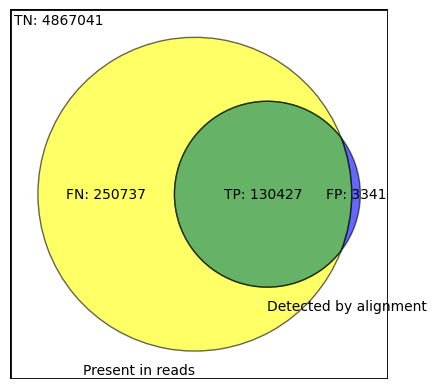

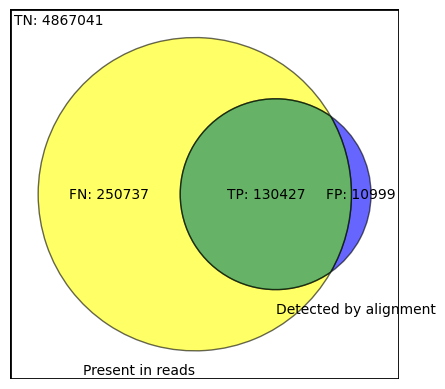

/home/jrich/Desktop/varseek/varseek/utils/visualization_utils.py:362: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(group_col).sum()


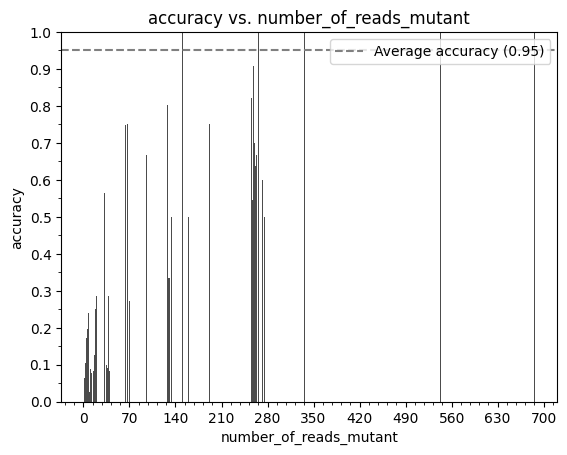

In [33]:
unique_mcrs_df['mutation_detected_gatk_haplotypecaller'] = unique_mcrs_df['header_list'].apply(
    lambda header_list: any(header in id_set_hap for header in header_list)
)

# calculate expression error
unique_mcrs_df['mutation_expression_prediction_error'] = unique_mcrs_df['DP_gatk_haplotypecaller'] - unique_mcrs_df['number_of_reads_mutant']  # positive means overpredicted, negative means underpredicted

unique_mcrs_df['TP'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['mutation_detected_gatk_haplotypecaller'])
unique_mcrs_df['FP'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['mutation_detected_gatk_haplotypecaller'])
unique_mcrs_df['FN'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['mutation_detected_gatk_haplotypecaller'])
unique_mcrs_df['TN'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['mutation_detected_gatk_haplotypecaller'])

haplotypecaller_stat_path = f"{gatk_parent}/reference_metrics_haplotypecaller.txt"
metric_dictionary_reference = calculate_metrics(unique_mcrs_df, header_name = "mcrs_header", check_assertions = False, out = haplotypecaller_stat_path)
draw_confusion_matrix(metric_dictionary_reference)

true_set = set(unique_mcrs_df.loc[unique_mcrs_df['included_in_synthetic_reads_mutant'], 'mcrs_header'])
positive_set = set(unique_mcrs_df.loc[unique_mcrs_df['mutation_detected_gatk_haplotypecaller'], 'mcrs_header'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reference['TN'], out_path = f"{gatk_parent}/venn_diagram_reference_cosmic_only_haplotypecaller.png")

noncosmic_mutation_id_set = {f'haplotypecaller_fp_{i}' for i in range(1, number_of_mutations_haplotypecaller - number_of_cosmic_mutations_haplotypecaller + 1)}

positive_set_including_noncosmic_mutations = positive_set.union(noncosmic_mutation_id_set)
false_positive_set = set(unique_mcrs_df.loc[unique_mcrs_df['FP'], 'mcrs_header'])
false_positive_set_including_noncosmic_mutations = false_positive_set.union(noncosmic_mutation_id_set)

FP_including_noncosmic = len(false_positive_set_including_noncosmic_mutations)
accuracy, sensitivity, specificity = calculate_sensitivity_specificity(metric_dictionary_reference['TP'], metric_dictionary_reference['TN'], FP_including_noncosmic, metric_dictionary_reference['FN'])

with open(haplotypecaller_stat_path, "a") as file:
    file.write(f"FP including non-cosmic: {FP_including_noncosmic}\n")
    file.write(f"accuracy including non-cosmic: {accuracy}\n")
    file.write(f"specificity including non-cosmic: {specificity}\n")



create_venn_diagram(true_set, positive_set_including_noncosmic_mutations, TN = metric_dictionary_reference['TN'], out_path = f"{gatk_parent}/venn_diagram_reference_including_noncosmics_haplotypecaller.png")

unique_mcrs_df.rename(columns={'TP': 'TP_gatk_haplotypecaller', 'FP': 'FP_gatk_haplotypecaller', 'TN': 'TN_gatk_haplotypecaller', 'FN': 'FN_gatk_haplotypecaller', 'mutation_expression_prediction_error': 'mutation_expression_prediction_error_gatk_haplotypecaller'}, inplace=True)


In [34]:
unique_mcrs_df_out = unique_mcrs_df_path.replace(".csv", "_with_gatk.csv")
unique_mcrs_df.to_csv(unique_mcrs_df_out, index=False)